# Deeplab v3+

This notebook shows how to train a Deeplab v3+ semantic segmentation model on a custom coco-style data set.

In [10]:
import os
import sys
import numpy as np

sys.path.insert(0, '../libraries')
from wdeeplab.config import Config
import wdeeplab.model as modellib
import wdeeplab.utils as utils
import wdataset.coco as coco

%matplotlib inline

HOME_DIR = '/home/keras'
DATA_DIR = os.path.join(HOME_DIR, "data/shapes")
MODEL_DIR = os.path.join(DATA_DIR, "logs")
PASCAL_WEIGHTS_PATH = os.path.join(HOME_DIR, "weights/deeplabv3_weights_tf_dim_ordering_tf_kernels.h5")
if not os.path.exists(PASCAL_WEIGHTS_PATH):
    utils.download_trained_weights(HOME_DIR)


## Dataset

Organize the dataset using the following structure:


    DATA_DIR
    │
    └───annotations
    │   │   instances_<subset><year>.json
    │   
    └───<subset><year>
        │   image021.jpeg
        │   image022.jpeg



In [2]:
dataset_train = coco.CocoDataset()
dataset_train.load_coco(DATA_DIR, subset="shapes_train", year="2018")
dataset_train.prepare()

loading annotations into memory...
Done (t=0.11s)
creating index...
index created!


## Configuration

In [3]:
image_size = 64
rpn_anchor_template = (1, 2, 4, 8, 16) # anchor sizes in pixels
rpn_anchor_scales = tuple(i * (image_size // 16) for i in rpn_anchor_template)

class ShapesConfig(Config):
    """Configuration for training on the shapes dataset.
    """
    NAME = "shapes"

    # Train on 1 GPU and 1 images per GPU. Put multiple images on each
    # GPU if the images are small.
    # BATCH_SIZE = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 shapes (triangles, circles, and squares)

    # Use smaller images for faster training. 
    IMAGE_MAX_DIM = image_size
    IMAGE_MIN_DIM = image_size
    
    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = rpn_anchor_scales

    # Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    STEPS_PER_EPOCH = 200

    VALIDATION_STEPS = STEPS_PER_EPOCH / 20
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  64
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  64
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [64 64  3]
INPUT_SHAPE                    [64 64  3]
INPUT_SHAPE_OUTPUT_FEATURE_RATIO 16
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCE

## Training

Load pretrained weights and train in two stages: just heads, then finetune 

In [4]:
model = modellib.DeepLabThreePlus(mode="training", config=config, model_dir=MODEL_DIR)

In [5]:
inititalize_weights_with = "pascal"  # pascal or last

if inititalize_weights_with == "pascal":
    model.load_weights(PASCAL_WEIGHTS_PATH, by_name=True)


### Heads

Train just the heads of the model

### Fine Tuning

Fine tune lower layers of the model

## Detection

Run the model on a random image from the test dataset and display the results

In [6]:
original_image = dataset_train.load_image(1)

In [7]:
results = model.detect([original_image], verbose=1)

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 64, 64, 3)        min:   -1.48510  max:   -0.53216  float32
image_metas              shape: (1, 16)               min:    0.00000  max:  512.00000  float64
1/1 [==============================] - 5s 5s/step


## Evaluation

Evaluate the performance of the model on the full test dataset

In [18]:
test = ((results[0]+1)*255).astype(np.uint8)

In [30]:
l1 = test[:,:,1]

In [24]:
import matplotlib.pyplot as plt

In [31]:
np.shape(l1)

(64, 64)

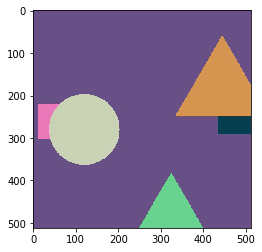

In [38]:
plt.imshow(original_image)

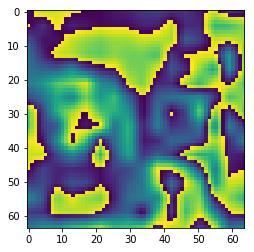

In [41]:
plt.imshow(test[:,:,3])